In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('C:\\Users\\ASUS\\source\\repos\\cleaned_dataset.csv')

In [4]:
print(df.select_dtypes(include='object').columns)

Index(['roomAndLivingRoom', 'registerState', 'bulunan_yonler', 'property_type',
       'price_category', 'area_name', 'county_name', 'sakarya_center_category',
       'karasu_category', 'sapanca_category', 'sakarya_university_category',
       'floorName', 'usage_name', 'yakit', 'isitma', 'yapiDurumu',
       'residence_name'],
      dtype='object')


In [5]:
df = df.drop(columns=['bulunan_yonler', 'property_type', 'floorName', 'isitma', 'residence_name'])

In [6]:
print(df.select_dtypes(include='object').columns)

Index(['roomAndLivingRoom', 'registerState', 'price_category', 'area_name',
       'county_name', 'sakarya_center_category', 'karasu_category',
       'sapanca_category', 'sakarya_university_category', 'usage_name',
       'yakit', 'yapiDurumu'],
      dtype='object')


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['price_category'] = le.fit_transform(df['price_category'].astype(str))
df['county_name'] = le.fit_transform(df['county_name'].astype(str))
df['area_name'] = le.fit_transform(df['area_name'].astype(str))

df['sakarya_center_category'] = le.fit_transform(df['sakarya_center_category'].astype(str))
df['karasu_category'] = le.fit_transform(df['karasu_category'].astype(str))
df['sapanca_category'] = le.fit_transform(df['sapanca_category'].astype(str))
df['sakarya_university_category'] = le.fit_transform(df['sakarya_university_category'].astype(str))

In [8]:
print(df.select_dtypes(include='object').columns)


Index(['roomAndLivingRoom', 'registerState', 'usage_name', 'yakit',
       'yapiDurumu'],
      dtype='object')


In [9]:
df = df.drop(columns=['roomAndLivingRoom'])
df = df.drop(columns=[
    'registerState',
    'yakit',
    'yapiDurumu',
    'usage_name'
])


In [10]:
df.columns

Index(['price', 'room', 'livingRoom', 'bathRoom', 'age', 'credit', 'barter',
       'furnished', 'onlineVisit', 'hasBranded', 'image_count',
       'inAttributes_count', 'outAttributes_count', 'locationAttributes_count',
       'inAttributes_count_is_missing', 'outAttributes_count_is_missing',
       'locationAttributes_count_is_missing', 'price_category',
       'fee_is_missing', 'days_since_update', 'Stale_corrected', 'duration',
       'area_name', 'county_name', 'tier', 'distance_to_sakarya_center_km',
       'distance_to_karasu_km', 'distance_to_sapanca_km',
       'distance_to_sakarya_university_km', 'sakarya_center_category',
       'karasu_category', 'sapanca_category', 'sakarya_university_category',
       'floorCount', 'floorNameFloat', 'floorCountFloat', 'floorRatio',
       'netSqm', 'grossSqm', 'sqm_fark', 'housingComplex_cleaned',
       'rental_amount', 'is_outlier_price', 'tier_brand_ratio',
       'tier_is_branded_only', 'county_brand_ratio',
       'property_type_bran

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import lightgbm as lgb
import xgboost as xgb

In [12]:
# Fiyatla ilgili sütunlar
price_related_cols = ['price', 'rental_amount', 'is_outlier_price']

# Var olanları kontrol edip kaldır çünkü modelin kafasını karıştırıyor sadece kategoriye odaklanması gerek
cols_to_drop = [col for col in price_related_cols if col in df.columns]
df = df.drop(columns=cols_to_drop)

print("Kaldırılan sütunlar:", cols_to_drop)


Kaldırılan sütunlar: ['price', 'rental_amount', 'is_outlier_price']


In [13]:
# Hedef ve özellik sütunlarını ayır
X = df.drop(columns=['price_category'])  # Özellikler
y = df['price_category']                 # Hedef değişken

# Eğitim ve test veri setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
rf_model = RandomForestClassifier(
    n_estimators=100,      # Ağaç sayısı
    max_depth=None,        # Derinlik sınırı yok
    random_state=42,
    class_weight='balanced'  # Sınıf dengesizliği varsa faydalı
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [15]:
# Test seti üzerinde tahmin yap
y_pred = rf_model.predict(X_test)

# Performans ölçümleri
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8294392523364486

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79       109
           1       0.81      0.87      0.84       218
           2       0.87      0.84      0.85       101

    accuracy                           0.83       428
   macro avg       0.84      0.82      0.83       428
weighted avg       0.83      0.83      0.83       428



In [16]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softmax',
    num_class=len(y.unique()),
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("🔹 XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


🔹 XGBoost Accuracy: 0.8154205607476636
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       109
           1       0.80      0.85      0.83       218
           2       0.83      0.81      0.82       101

    accuracy                           0.82       428
   macro avg       0.82      0.80      0.81       428
weighted avg       0.82      0.82      0.81       428



In [17]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(y.unique()),
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("🔹 LightGBM Accuracy:", accuracy_score(y_test, lgb_preds))
print(classification_report(y_test, lgb_preds))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1709, number of used features: 57
[LightGBM] [Info] Start training from score -1.361445
[LightGBM] [Info] Start training from score -0.676321
[LightGBM] [Info] Start training from score -1.447212
🔹 LightGBM Accuracy: 0.822429906542056
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       109
           1       0.81      0.86      0.83       218
           2       0.83      0.79      0.81       101

    accuracy                           0.82       428
   macro avg       0.83      0.81      0.82       428
weighted avg       0.82      0.82      0.

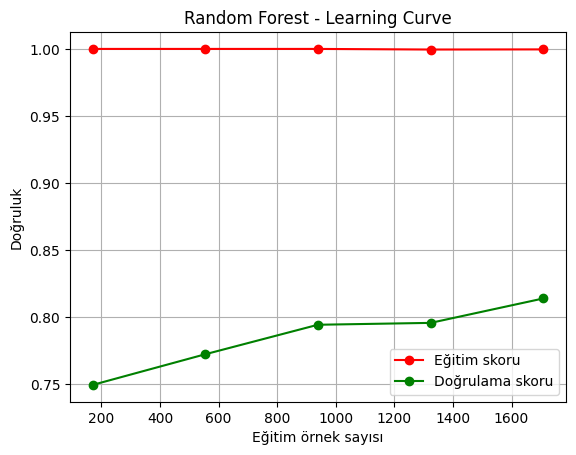

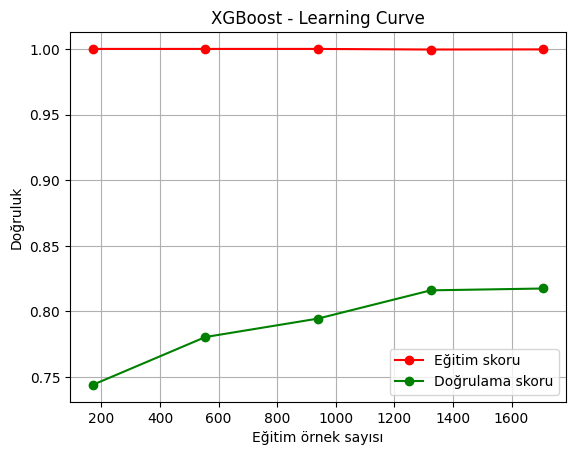

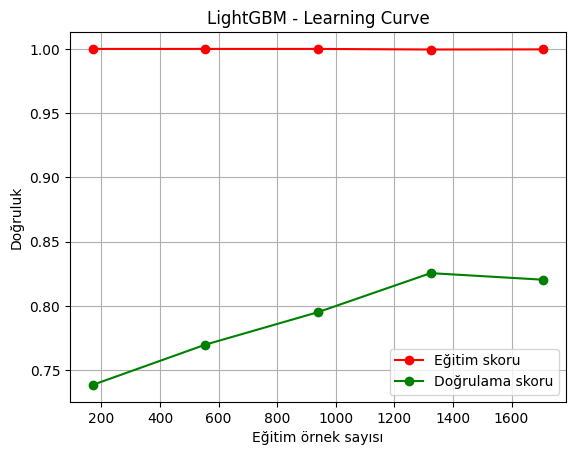

In [18]:

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# Hedef ve özellikler
target = 'price_category'
X = df.drop(columns=[target])
y = df[target]

# Kategorik değişkenleri sayısala çevir
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Kayıp verileri doldur
X = X.fillna(-999)

# Öğrenme eğrisi fonksiyonu
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator,
        X, y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Eğitim skoru")
    plt.plot(train_sizes, valid_mean, 'o-', color="g", label="Doğrulama skoru")
    plt.title(title)
    plt.xlabel("Eğitim örnek sayısı")
    plt.ylabel("Doğruluk")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Modeller
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Hepsi için çiz
for name, model in models.items():
    plot_learning_curve(model, f"{name} - Learning Curve")

modeller overfit durumda 

En önemli 20 özellik:
                              feature  importance
35                             netSqm    0.088386
36                           grossSqm    0.078611
0                                room    0.070240
61                     property_Daire    0.064705
2                            bathRoom    0.051705
24              distance_to_karasu_km    0.050726
25             distance_to_sapanca_km    0.041645
23      distance_to_sakarya_center_km    0.041147
26  distance_to_sakarya_university_km    0.040486
9                         image_count    0.036654
42        property_type_branded_ratio    0.031864
37                           sqm_fark    0.028155
3                                 age    0.027723
17                  days_since_update    0.026401
66                     property_Villa    0.023276
34                         floorRatio    0.022648
32                     floorNameFloat    0.020782
6                           furnished    0.020231
41                 county_br

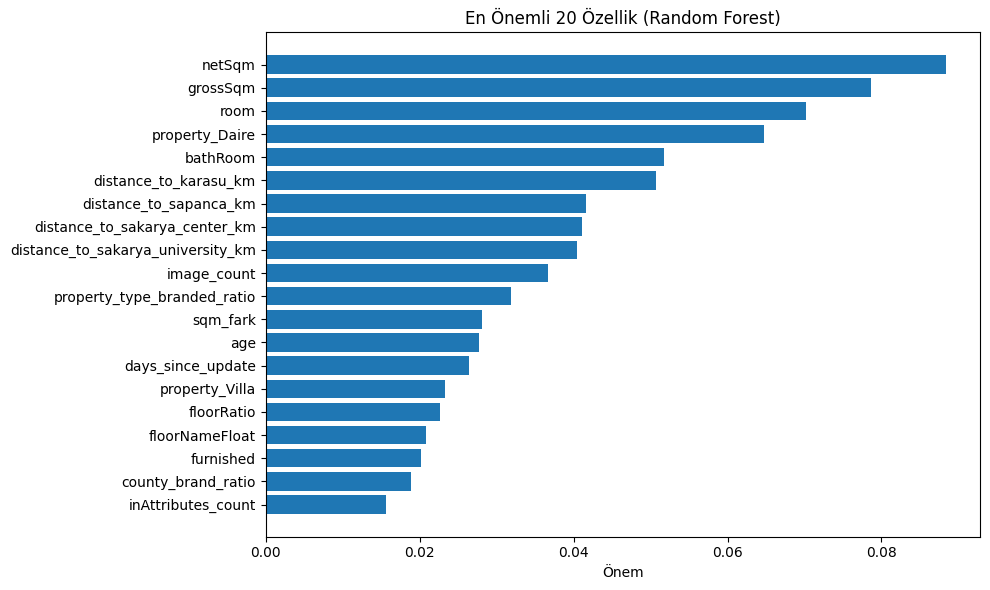

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Özellik önemleri
importances = rf_model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = feature_importance_df.head(20)
print("En önemli 20 özellik:")
print(top_features)

# Grafiği çiz
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.title("En Önemli 20 Özellik (Random Forest)")
plt.xlabel("Önem")
plt.tight_layout()
plt.show()

In [20]:
valid_features = [f for f in top_features['feature'] if f in X.columns]

X_train_selected = X_train[valid_features]
X_test_selected = X_test[valid_features]

print(f"Özellik sayısı önce: {X_train.shape[1]}")
print(f"Özellik sayısı sonra: {X_train_selected.shape[1]}")


Özellik sayısı önce: 69
Özellik sayısı sonra: 20


In [ ]:
#Decision Tree ile model eğitildi.

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Basit bir Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=5,              # Aşırı öğrenmeyi önlemek için derinlik kısıtlaması
    min_samples_split=10,     # Dallanma için gereken minimum örnek sayısı
    min_samples_leaf=5,       # Yaprak düğümdeki minimum örnek sayısı
    class_weight='balanced',  # Sınıf dengesizliği varsa dengele
    random_state=42
)

# Modeli eğit
dt_model.fit(X_train_selected, y_train)

# Tahmin ve sonuç
y_pred_dt = dt_model.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Accuracy: 0.7313084112149533
              precision    recall  f1-score   support

           0       0.58      0.86      0.69       109
           1       0.85      0.58      0.69       218
           2       0.79      0.91      0.85       101

    accuracy                           0.73       428
   macro avg       0.74      0.79      0.74       428
weighted avg       0.77      0.73      0.73       428



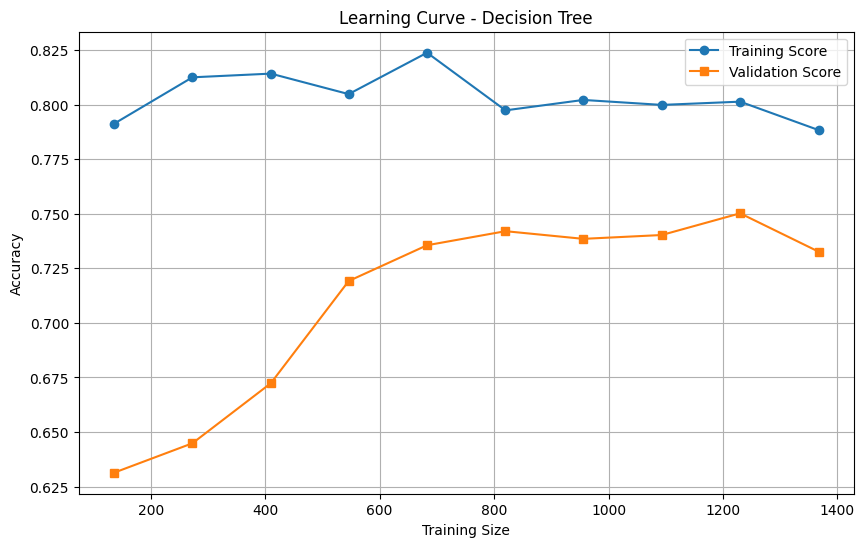

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    dt_model, X_train_selected, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score', marker='o')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Score', marker='s')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

Randomforest için parametre ayarlamaları

In [22]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [ ]:
#RandomizedSearch ile en iyi parametre bulma
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid_rf,
    n_iter=30,  # Rastgele 30 kombinasyonu dener
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_selected, y_train)

print("En iyi parametreler:", random_search.best_params_)
print("En iyi skor:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
En iyi parametreler: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}
En iyi skor: 0.8250381574660013


In [ ]:
#Bulunan sonuca göre parametreler ayarlandı. 
best_rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=15,
    bootstrap=False,
    class_weight='balanced',
    random_state=42
)

best_rf.fit(X_train_selected, y_train)

# Tahmin
y_pred_rf = best_rf.predict(X_test_selected)

# Metrikler
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.79       109
           1       0.82      0.84      0.83       218
           2       0.84      0.86      0.85       101

    accuracy                           0.82       428
   macro avg       0.83      0.82      0.82       428
weighted avg       0.82      0.82      0.82       428



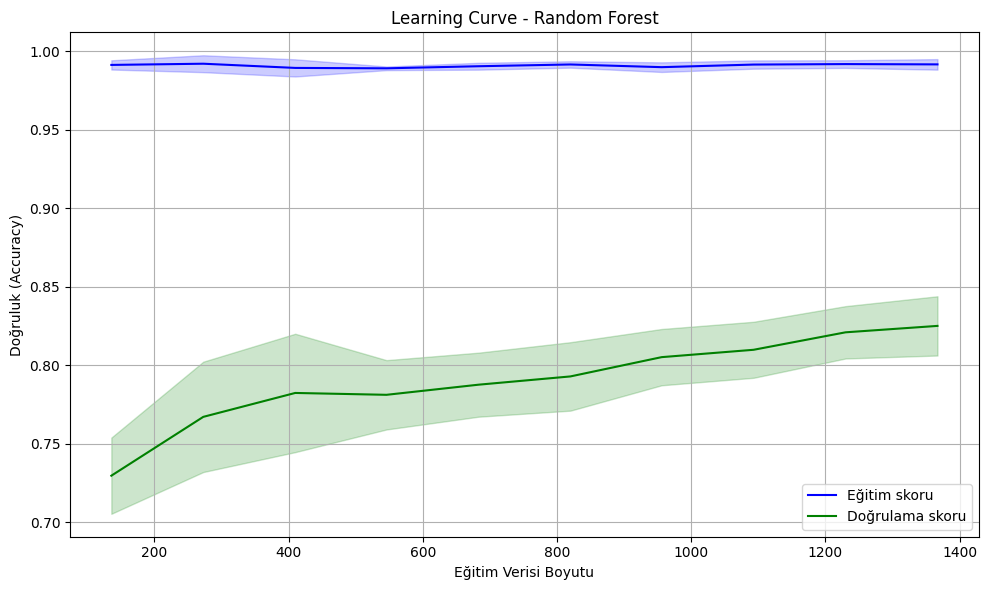

In [25]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Learning curve hesaplama
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_rf,
    X=X_train_selected,
    y=y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Ortalama ve standart sapmalar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Eğitim skoru', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, label='Doğrulama skoru', color='green')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

plt.title('Learning Curve - Random Forest')
plt.xlabel('Eğitim Verisi Boyutu')
plt.ylabel('Doğruluk (Accuracy)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


randomsearch yöntemiyle parametreler belirlendiğinde model hala overfit durumda olmaya devam etti.

In [ ]:
#Gridsearch ile en iyi parametreleri bulma
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_selected, y_train)

print("En iyi parametreler (grid):", grid_search.best_params_)
print("En iyi skor (grid):", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
En iyi parametreler (grid): {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
En iyi skor (grid): 0.8273756238102588


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# En iyi parametrelerle model
final_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    bootstrap=False,
    class_weight='balanced',
    random_state=42
)

# Eğitimi
final_rf.fit(X_train_selected, y_train)

# Test seti tahmin
y_pred_rf = final_rf.predict(X_test_selected)

# Sonuçlar
print("Classification Report:\n", classification_report(y_test, y_pred_rf))



Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.77       109
           1       0.81      0.83      0.82       218
           2       0.84      0.86      0.85       101

    accuracy                           0.81       428
   macro avg       0.81      0.81      0.81       428
weighted avg       0.81      0.81      0.81       428



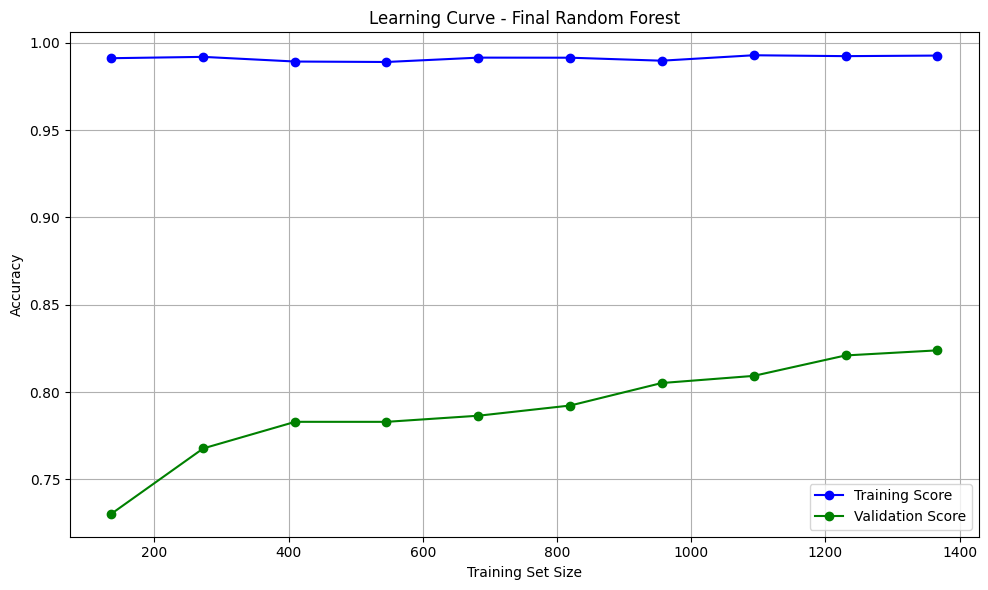

In [29]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Learning curve için skorları al
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=final_rf,
    X=X_train_selected,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Ortalama skorları hesapla
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='blue')
plt.plot(train_sizes, valid_mean, 'o-', label='Validation Score', color='green')
plt.title('Learning Curve - Final Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model hala overfit durumda başta belirlenen parametre alanlarını daraltıp tekrar GridSearch deneyerek en iyi sonucu bulalım. (Tüm kombinasyonlar denendiği için grid ile arama yavaş sürüyor)

In [ ]:
#parametre alanı daraltılıp grid ile tekrar arama yapıldığında en iyi sonuç eldi edildi.
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_selected, y_train)

print("En iyi parametreler (Grid):", grid_search.best_params_)
print("En iyi doğrulama skoru (Grid):", grid_search.best_score_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
En iyi parametreler (Grid): {'bootstrap': False, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
En iyi doğrulama skoru (Grid): 0.7647888048567166


In [33]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_selected)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.67      0.86      0.75       109
           1       0.87      0.70      0.78       218
           2       0.83      0.93      0.88       101

    accuracy                           0.79       428
   macro avg       0.79      0.83      0.80       428
weighted avg       0.81      0.79      0.79       428



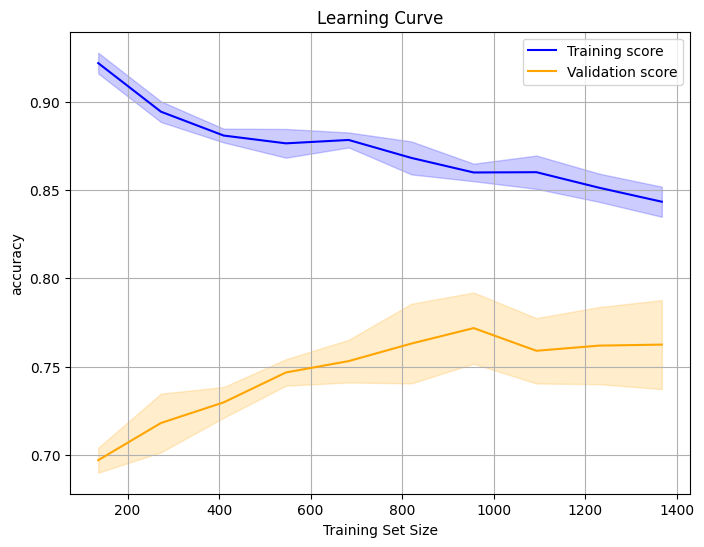

In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy'):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, valid_mean, label='Validation score', color='orange')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='orange')
    plt.xlabel('Training Set Size')
    plt.ylabel(scoring)
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Çizimi yapalım
plot_learning_curve(best_rf, X_train_selected, y_train)


GridSearch ile bulunan parametrelerle birlikte, ve ilk 20 önemli özellik baz alınarak en iyi model random forest olarak belirlenmiştir. Model artık overfit durumda değildir.